In [1]:
# Imported modules
import sys
sys.path.append("/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs")
from tools import constants

import pandas as pd 
import numpy as np 

import sys # To run the batch script

import os # To check if file exists.

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt 

In [2]:
def h2_mass_fraction_calculator(
    local_density_scale_height, 
    density, 
    metallicity, 
    clumping_factor
):

    print("I am in the function h2_mass_fraction_calculator") 


    """This function is used to calculate the H2 mass fraction by using the formula 1 in the paper:
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    Arguments:
    ----------
    local_density_scale_height: array_like
        In this equation smooting length of the gas is assumed to be accurate estimation of the local density scale height. 
        Therefore smooting length is used instead of local density scale height
        [pc]

    density: array_like
        Density of the gas particles
        [gr / cm^3]

    metallicity: array_like
        metallicity of the gas particles 
        [Zsolar]

    clumping_factor: double or int
        It is a parameter to boost the h2 mass fraction and therefore h2 column density and CO luminosity
        [unitless]

    Returns:
    ----------
    h2_mass_fraction: array_like
        h2_mass_fraction = h2_gas_mass / total_gas_mass
        [unitless]

    column_density: array_like
        It is the column density considering all elements in the gas particle
        [gr/cm^2]

    dust_optical_depth: array_like  
        tau_c in the reference paper. It was being output in order to control the code
        [unitless]

    References: 
    -----------
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    """ 


    # The units of local_density_scale_height is kpc 
    local_density_scale_height = local_density_scale_height * constants.pc2cm  # [cm]

    # Calculation of column density 
    column_density = density * local_density_scale_height   # [gr / cm^2]
    # Column density is the summation sign in the paper
    # Gunjan assumed that local density scale height is same with the smoooting length of the gas particles. I will continue on this assumption
    # but I don't know how it works

    # Calculation of dust cross section (sigma_d in txhe paper)
    dust_cross_section_per_H_nucleus_normalized_to_1eminus21 = metallicity
    dust_cross_section = dust_cross_section_per_H_nucleus_normalized_to_1eminus21 * 1e-21   # [cm^2]


    # Calculation of dust optical depth (tau_c in the paper)
    # mu_h is the mean mass per H nucleus
    mu_h = 2.3e-24  # [gr] 
    # clumping factor is used to increase the H2 formation to account for density inhomogeneities that are unresolved on the computational grid
    # since the H2 formation rate varies as the square of density, these inhomogeneities increase the overall rate
    dust_optical_depth = clumping_factor * column_density * dust_cross_section / mu_h     # [dimensionless]   

    # Calculation for scaled radiation field (chi in the paper) Eq 4 
    # This scaled radiation field will not likely to hold cell-by-cell every time step, but it should hold on average
    # clumping factor is used to boost the formation rate of the H2 molecules on dust grains (the R term)   
    scaled_radiation_field = 3.1 * (1 + 3.1 * metallicity**0.365) / 4.1  # [dimensionless]

    # Calculation for s in the paper (Eq 2)
    s = np.log(1 + 0.6*scaled_radiation_field + 0.01 * scaled_radiation_field**2 ) / ( 0.6 * dust_optical_depth )
    
    # If s > 2 then fh2 < 0 which is unphysical. So set s greter than 2 to 2. 
    s[s>2] = 2

    # Calculation for the H2 mass fraction (f_H2 in the paper Eq 1)
    h2_mass_fraction = 1 - (3/4) * (s / (1 + 0.25*s))   # [dimensionless]
    
    return h2_mass_fraction, column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth



def X_co_calculator(
    h2_column_density, 
    metallicity, 
):
    print("I am in the function X_co_calculator")

    """This function is being used in order to calculate the X_co for each annulus

    Arguments:
    ----------
    h2_column_density: array-like
        h2_column_density for each particle 
        [gr/cm^2]

    metallicity: array-like
        [Zsolar]

    Returns:
    ----------
    X_co: vector 
        CO conversion factor for each particle
        [cm^-2 /K-km s^-1]
        
    X_co_solar_metallicity: vector
        X_co when metallicity is set to solar metallicity
        [cm^-2 /K-km s^-1]

    References: 
    -----------
    A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)

    """ 


    h2_column_density = h2_column_density * constants.gr2M_sun / (constants.cm2pc)**2   
    # h2_column_density [M_sun/pc^2]

    # A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)
    # Eq 6 

    X_co = 1.3e21/(metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    ####    

    X_co_solar_metallicity = 1.3e21/(constants.solar_metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    # Set inf values to NaN. This happens when s >= 2, which it sets fh2 = 0 and h2 column density to zero consequtively and Xco to infinity.
    # Replace inf/-inf with NaN
    X_co[np.isinf(X_co)] = np.nan #
    X_co_solar_metallicity[np.isinf(X_co_solar_metallicity)] = np.nan
    
    
    return X_co, X_co_solar_metallicity


def clumping_factor_from_turbulence_velocity(turbulence_velocity):
    
    """
    """
    
    MW_turbulence = 5 # km/s 
    MW_clumping = 1 # 
    
    clumping_factor = MW_clumping * (turbulence_velocity / MW_turbulence)**2 
    
    # Clumping factor can be 1 smallest. 
    clumping_factor[clumping_factor < 1] = 1
    
    return clumping_factor


In [3]:
def main(galaxy_name, galaxy_type, redshift, run_dir):

    cloudy_gas_particles_file_directory = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/{run_dir}" 

    print(f"Starting reading gas particles.")
    # Define the column names based on your description
    gas_column_names = [
        "x", 
        "y", 
        "z", 
        "smoothing_length", 
        "mass", 
        "metallicity", # Zsolar but will be converted to mass fraction in the future
        "temperature", 
        "vx", 
        "vy", 
        "vz", 
        "hden", 
        "radius", 
        "sfr", 
        "turbulence", 
        "density", 
        "mu_theoretical", 
        "average_sobolev_smoothingLength",
        "index", 
        "isrf"
    ]


    gas_particles_df = pd.read_csv(
        f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt",
        delim_whitespace=True, 
        comment='#', 
        names=gas_column_names
    )
    print(f"Finished reading gas particles.")


    gas_particles_df["clumping_factor"] = clumping_factor_from_turbulence_velocity(
        turbulence_velocity=gas_particles_df["turbulence"]
    )
    
    
    h2_mass_fraction, gas_column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth = h2_mass_fraction_calculator(
        local_density_scale_height = np.array(gas_particles_df["average_sobolev_smoothingLength"]), # pc
        density = np.array(gas_particles_df["density"]), # gr / cm^3
        metallicity= np.array(gas_particles_df["metallicity"]),  # Zsolar
        clumping_factor = gas_particles_df["clumping_factor"]
    )
    gas_particles_df["fh2"] = h2_mass_fraction
    gas_particles_df["Mh2"] = gas_particles_df["mass"] * gas_particles_df["fh2"]
    gas_particles_df["tau_c"] = dust_optical_depth
    

    # Findind the column density of gas particles. 
    h2_column_density = h2_mass_fraction * gas_column_density  # [gr/cm^2]  

    # Estimating the Xco of gas particles. 
    gas_particles_df["Xco"], Xco_solar_metallicity = X_co_calculator(
        h2_column_density = h2_column_density,  # [gr / cm^2]
        metallicity = np.array(gas_particles_df["metallicity"]), # Zsolar
    )    

    # Calculating Lco
    alfa_co = gas_particles_df["Xco"] / 6.3e19 # [M_solar/pc^-2 (K-km s^-1)^-1]

    gas_particles_df["L_co"] = gas_particles_df["Mh2"] / alfa_co 
    gas_particles_df["L_co"].fillna(0, inplace=True) # Set NaN to zero.

    return gas_particles_df

In [4]:
galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"
redshift = "3.0"
run_dir = "voronoi_1e6"

gas_particles_df = main(
    galaxy_name = galaxy_name, 
    galaxy_type = galaxy_type, 
    redshift = redshift, 
    run_dir = run_dir, 
)



total_sfr = sum(gas_particles_df['sfr'])
print(f"Total sfr: {np.round(total_sfr, 2)} Msolar / year")

total_gas_mass = sum(gas_particles_df['mass'])
print(f"Total gas mass: {np.round(total_gas_mass/1e9, 2)} E9")

total_h2_mass = sum(gas_particles_df['Mh2'])
print(f"Total H2 mass: {np.round(total_h2_mass/1e9, 4)} E9")

total_Lco = sum(gas_particles_df['L_co'])
print(f"Total Lco: {np.round(total_Lco/1e9, 4)} E9")

Starting reading gas particles.
Finished reading gas particles.
I am in the function h2_mass_fraction_calculator
I am in the function X_co_calculator
Total sfr: 2.5 Msolar / year
Total gas mass: 12.81 E9
Total H2 mass: 0.4648 E9
Total Lco: 0.0165 E9


# Reading observations 

In [5]:
from tools import functions_importing_observations as func_observations

################# Importing data from observations 

base_dir = "/mnt/raid-cita/dtolgay/Observations"
    
# ### Ly_alpha
# HETDEX_df = func_observations.hetdex_data_reading(f"/mnt/raid-cita/dtolgay/Observations/hetdex_sc1_v3.2.ecsv")
# hayes_2014 = func_observations.HAYES_2014_data_reading("/mnt/raid-cita/dtolgay/Observations/hayes_2014.xlsx")
# cowie_2011 = func_observations.cowie_2011_lya_reading("/mnt/raid-cita/dtolgay/Observations/cowie_2011_lya.xlsx")

### C0
xCOLDGASS_file_path = "/mnt/raid-cita/dtolgay/Observations/xCOLDGASS_PubCat.fits"
XCOLDGASS_df = func_observations.XCold_Gass_data_reading(filedir=xCOLDGASS_file_path)

PHIBSS2_file_path = "/mnt/raid-cita/dtolgay/Observations/PHIBSS2_data.xlsx" 
PHIBBS2_df = func_observations.PHIBSS2_data_reading(filedir=PHIBSS2_file_path)

ALMA_2019_file_path = "/mnt/raid-cita/dtolgay/Observations/ALMA_2019_data.xlsx"
ALMA_df = func_observations.ALMA_2019_Data_Reading(filedir=ALMA_2019_file_path)

Leroy_file_path = "/mnt/raid-cita/dtolgay/Observations/Leroy_data.xlsx"
Leroy_df, average_radius_r25_times_075_LEROY = func_observations.Leroy_Data_Reading(filedir=Leroy_file_path)


# ### h alpha
# young_1996 = func_observations.young_1996("/mnt/raid-cita/dtolgay/Observations/young_1996.xlsx")
# james_2014 = func_observations.james_2024("/mnt/raid-cita/dtolgay/Observations/james_2014_h_alpha.dat")

Laura_df = func_observations.laura_eyeballing_data_df_creator()

I am in the function XCold_Gass_data_reading
I am in the function PHIBSS2_data_reading
I am in the function ALMA_2019_Data_Reading
I am in the function Leroy_data_reading
average_radius_r25_times_075_LEROY:  8.886206896551723
I am in the function laura_eyeballing_data_df_creator


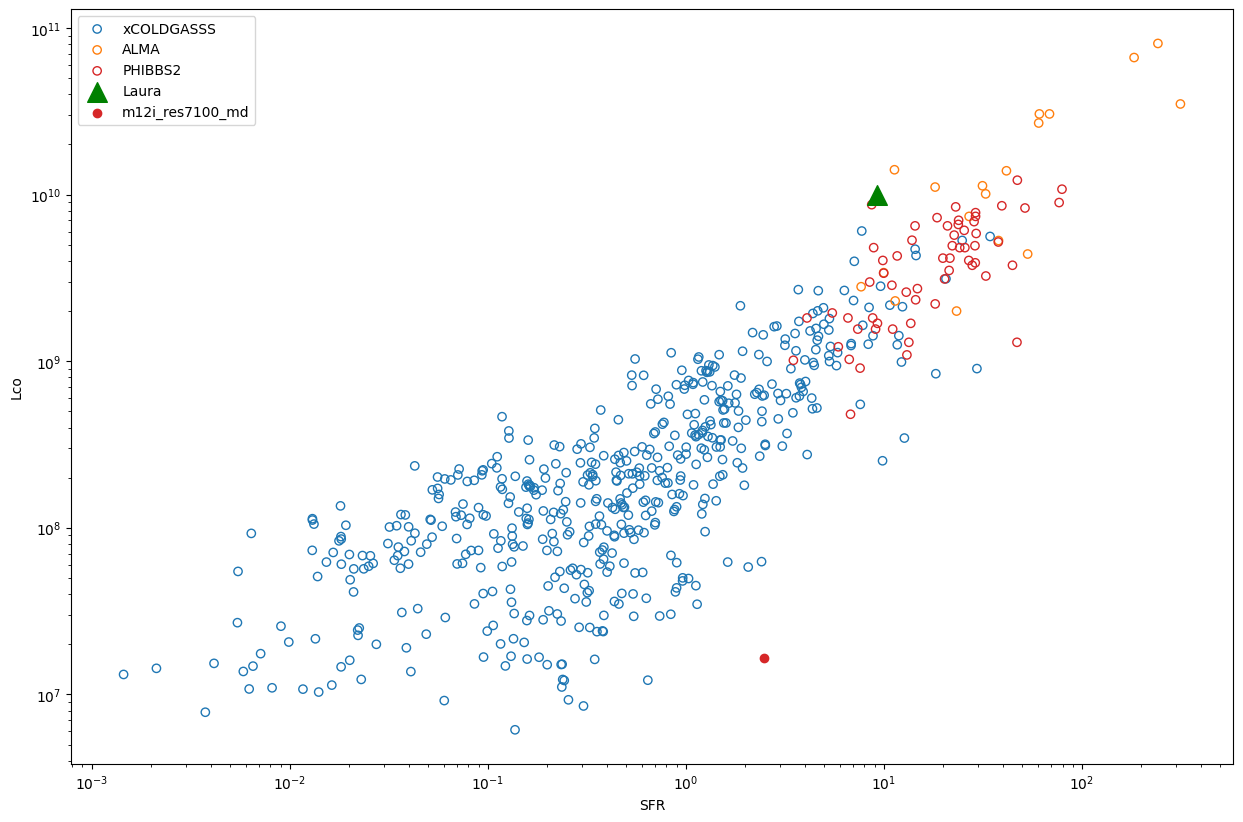

In [6]:
fig = plt.figure(figsize=(15, 10), dpi=100)

# xCOLDGASS
plt.scatter(XCOLDGASS_df['SFR'], XCOLDGASS_df['Lco'], facecolors='none', edgecolors='tab:blue', label = "xCOLDGASSS")
plt.scatter(ALMA_df['SFR'], ALMA_df['Lco'], facecolors='none', edgecolors='tab:Orange', label = "ALMA")
plt.scatter(PHIBBS2_df['SFR'], PHIBBS2_df['Lco'], facecolors='none', edgecolors='tab:Red', label = "PHIBBS2")

# ## Xcoldgass metallicity color plot
# plt.scatter(XCOLDGASS_df['SFR'], XCOLDGASS_df['Lco'], c=np.log10(XCOLDGASS_df["Mh2"]), cmap="GnBu", label = "xCOLDGASSS") 
# plt.colorbar(label="log10_Mh2", orientation="horizontal") 


# Laura
plt.scatter(Laura_df["SFR"], Laura_df["Lco"], marker = '^', s=200, c = "Green", label = "Laura")

# My work
plt.scatter(sum(gas_particles_df["sfr"]), np.sum(gas_particles_df["L_co"]), c = "tab:Red", label = f"{galaxy_name}")


plt.xlabel("SFR")
plt.ylabel("Lco")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper left")
plt.show()

In [ ]:
bins = np.linspace(0,3,100)
plt.hist(
    np.log10(gas_particles_df["clumping_factor"]),
    bins=bins
)
plt.xlabel("log10(clumping_factor)")
plt.yscale("log")
plt.show()